Assignment 5 - CNNs on cultural image data
DESCRIPTION

Multi-class classification of impressionist painters



So far in class, we've been working with 'toy' datasets - handwriting, cats, dogs, and so on. However, this course is on the application of computer vision and deep learning to cultural data. This week, your assignment is to use what you've learned so far to build a classifier which can predict artists from paintings.



You can find the data for the assignment here: https://www.kaggle.com/delayedkarma/impressionist-classifier-data



Using this data, you should build a deep learning model using convolutional neural networks which classify paintings by their respective artists. Why might we want to do this? Well, consider the scenario where we have found a new, never-before-seen painting which is claimed to be the artist Renoir. An accurate predictive model could be useful here for art historians and archivists!



For this assignment, you can use the CNN code we looked at in class, such as the ShallowNet architecture or LeNet. You are also welcome to build your own model, if you dare - I recommend against doing this.



Perhaps the most challenging aspect of this assignment will be to get all of the images into format that can be fed into the CNN model. All of the images are of different shapes and sizes, so the first task will be to resize the images to have them be a uniform (smaller) shape.



You'll also need to think about how to get the images into an array for the model and how to extract 'labels' from filenames for use in the classification report



Tips

You should save visualizations showing loss/accuracy of the model during training; you should also a save the output from the classification report
I suggest working in groups for this assignment. The data is quite large and will take some time to move over to worker02. Similarly training the models will be time consuming, so it is preferably to have fewer models on the go.
You might want to consider a division of labour in your group. One person working on resizing images, one working on extracting labels, one developing the model, etc.
For reshaping images, I suggest checking out cv.resize() with the cv2.INTER_AREA method
If you have trouble doing this on your own machines, use worker02
Don't worry if the results aren't great! This is a complex dataset we're working with




General instructions

Save your script as cnn-artists.py
If you have external dependencies, you must include a requirements.txt
You can either upload the script here or push to GitHub and include a link - or both!
Your code should be clearly documented in a way that allows others to easily follow along
Similarly, remember to use descriptive variable names! A name like X_train is (just) more readable than x1


Purpose

This assignment is designed to test that you have a understanding of:

how to build and train deep convolutional neural networks;
how to preprocess and prepare image data for use in these models;
how to work with complex, cultural image data, rather than toy datasets


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import cv2
from tqdm import tqdm
import sys
import random

sys.path.append(os.path.join(".."))
from utils.imutils import jimshow

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# tf tools
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten, 
                                     Dense,
                                     Dropout,
                                     BatchNormalization)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


ImportError: cannot import name 'plot_history'

In [3]:

training_dir = os.path.join("..", "data", "data_assignment5", "training", "training")

test_dir = os.path.join("..", "data", "data_assignment5", "validation", "validation")

def create_data(DATADIR,n = -1, IMG_SIZE = 64):
    data = []
    CATEGORIES = os.listdir(DATADIR)
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)[:n]):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                new_array = new_array/255
                data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
    
    random.shuffle(data)
    X = []
    y = []

    for features,label in data:
        X.append(features)
        y.append(label)


    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    lb = LabelBinarizer()
    y = lb.fit_transform(y)
    return (X,y)

X_train,y_train = create_data(training_dir)

X_test,y_test = create_data(test_dir)


100%|██████████| 98/98 [00:03<00:00, 31.41it/s]


### LeNet

In [12]:
image_size = 64

In [42]:
# define model
model = Sequential()

# first set of CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), 
                 padding="same", 
                 input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))
model.add(Dropout(0.2))

# second set of CONV => RELU => POOL
model.add(Conv2D(64, (5, 5), 
                 padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))
model.add(Dropout(0.2))

# FC => RELU

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))


# softmax classifier
model.add(Dense(10))
model.add(Activation("softmax"))

In [44]:

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.4,
        zoom_range=0.4,
        horizontal_flip=True)


# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 8
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        training_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical',
        interpolation = "lanczos")  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        interpolation = "lanczos")

callback = EarlyStopping(monitor='accuracy', patience=10, min_delta = 0.0001)
opt = SGD(lr=0.001, momentum = 0.9)
model.compile(loss="categorical_crossentropy",
              optimizer= opt,
              metrics=["accuracy"])

Found 3988 images belonging to 10 classes.
Found 990 images belonging to 10 classes.


In [45]:
batch_size = 32
H = model.fit(
        train_generator,
        epochs=10,
        batch_size = batch_size,
        steps_per_epoch = 4000//batch_size,
        validation_data=validation_generator,
        validation_steps = 1000//batch_size,
              verbose=1,
              callbacks=[callback]
        )

Epoch 1/10
125/125 [==============================] - 52s 409ms/step - loss: 2.6917 - accuracy: 0.1486 - val_loss: 2.5319 - val_accuracy: 0.1411
Epoch 2/10
125/125 [==============================] - 50s 398ms/step - loss: 2.3759 - accuracy: 0.1960 - val_loss: 2.3677 - val_accuracy: 0.1573
Epoch 3/10
125/125 [==============================] - 50s 398ms/step - loss: 2.2893 - accuracy: 0.2074 - val_loss: 2.1745 - val_accuracy: 0.1976
Epoch 4/10
125/125 [==============================] - 50s 399ms/step - loss: 2.1990 - accuracy: 0.2646 - val_loss: 2.0321 - val_accuracy: 0.2702
Epoch 5/10
125/125 [==============================] - 51s 407ms/step - loss: 2.2324 - accuracy: 0.2468 - val_loss: 2.5072 - val_accuracy: 0.2137
Epoch 6/10
125/125 [==============================] - 51s 407ms/step - loss: 2.1386 - accuracy: 0.2533 - val_loss: 1.9798 - val_accuracy: 0.2823
Epoch 7/10
125/125 [==============================] - 53s 426ms/step - loss: 2.0411 - accuracy: 0.2726 - val_loss: 2.0583 - val_ac

In [281]:
model.save_weights(os.path.join("..","data", "data_assignment5", "weights","model.h5"))


In [15]:
model.load_weights(os.path.join("..","data", "data_assignment5", "weights","model.h5"))

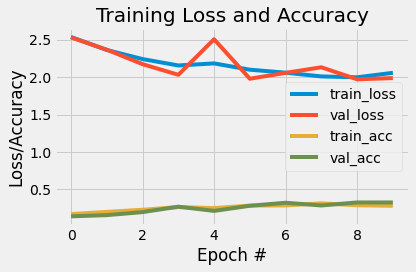

In [58]:
def plot_history(H, epochs,file_name):
    # visualize performance
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.draw()
    plt.savefig(file_name)
    plt.show()
plot_history(H,10,os.path.join("..","data", "data_assignment5", "out","history_plot.png"))


In [62]:


# get the ground truth of your data. 
test_labels=validation_generator.classes 

# predict the probability distribution of the data
predictions=model.predict(validation_generator, verbose=1)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
cr = classification_report(test_labels, y_pred)
print(cr)
filepath = os.path.join("..","data","data_assignment5","out","metrics.txt")
text_file = open(filepath, "w")
text_file.write(cr)
text_file.close()

124/124 [==============================] - 39s 316ms/step
              precision    recall  f1-score   support

           0       0.10      0.12      0.11        99
           1       0.07      0.05      0.06        99
           2       0.07      0.03      0.04        99
           3       0.07      0.04      0.05        99
           4       0.11      0.02      0.03        99
           5       0.05      0.02      0.03        99
           6       0.09      0.19      0.12        99
           7       0.05      0.05      0.05        99
           8       0.15      0.17      0.16        99
           9       0.11      0.24      0.15        99

    accuracy                           0.09       990
   macro avg       0.09      0.09      0.08       990
weighted avg       0.09      0.09      0.08       990

